In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *

In [32]:
# copy pasted from command center
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

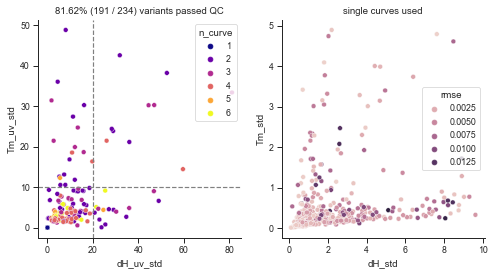

In [33]:
sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230317.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230317.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230317.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria=None,
                               Tm_std_thresh=10, dH_std_thresh=20,
                               sample_sheet_file=sample_sheet_file, clean=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

In [42]:
vf.columns

Index(['SEQID', 'curve_date', 'curve_num', 'dH_uv', 'dH_uv_std', 'n_curve',
       'Tm_uv', 'Tm_uv_std', 'dG_37_uv', 'dG_37_uv_std', 'dS_uv', 'dS_uv_std',
       'is_hairpin', 'Na_mM', 'conc_uM', 'Purification', 'dH', 'dH_se',
       'dH_lb', 'dH_ub', 'Tm', 'Tm_se', 'Tm_lb', 'Tm_ub', 'dG_37', 'dG_37_se',
       'dG_37_lb', 'dG_37_ub', 'dS', 'dS_se', 'dS_lb', 'dS_ub', 'fmax',
       'fmax_se', 'fmax_lb', 'fmax_ub', 'fmin', 'fmin_se', 'fmin_lb',
       'fmin_ub', 'Series', 'ConstructType', 'bottomScaffold', 'topScaffold',
       'RefSeq', 'dH_NUPACK', 'dS_NUPACK', 'Tm_NUPACK',
       'dG_37_ensemble_NUPACK', 'TargetStruct', 'dG_37_NUPACK',
       'dG_37_ensemble_150mM_NUPACK', 'dG_37_ensemble_75mM_NUPACK', 'GC',
       'Tm_NUPACK_salt_corrected', 'dG_37_NUPACK_salt_corrected',
       'dH_NUPACK_salt_corrected', 'dS_NUPACK_salt_corrected'],
      dtype='object')

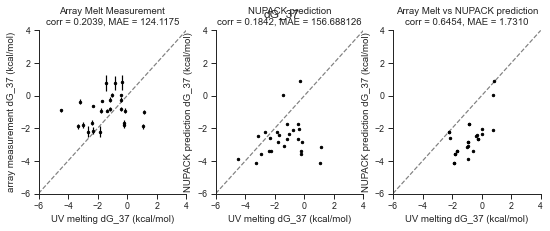

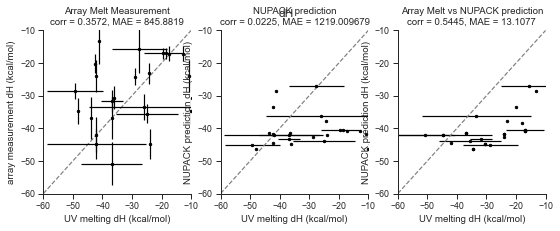

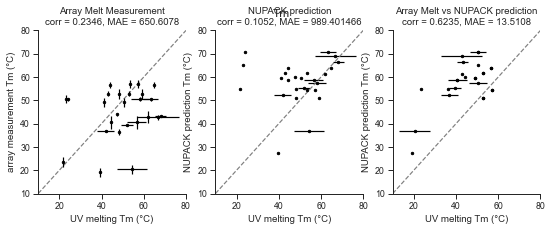

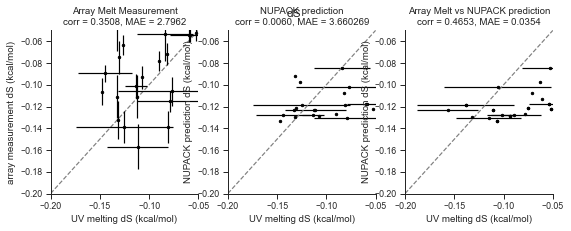

In [62]:
series = 'All'
plot_query = 'n_curve > 1'
df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    unit = unit_dict[param]
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   fmt='k.')
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})')
    ax[0].set_ylabel(f'array measurement {param} ({unit})')
    ax[0].set_title('Array Melt Measurement\ncorr = %.4f, MAE = %.4f' %
                    (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   fmt='k.')
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})')
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[1].set_title('NUPACK prediction\ncorr = %.4f, MAE = %4f' %
                    (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               fmt='k.')
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})')
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
                    (pearsonr(x, y)[0], mae(x, y)))
    
    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-6, 4))
util.save_fig(f'./fig/UV_melt/Fig2a/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
util.save_fig(f'./fig/UV_melt/Fig2a/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (10, 80))
util.save_fig(f'./fig/UV_melt/Fig2a/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05))
util.save_fig(f'./fig/UV_melt/Fig2a/{series}_dS.pdf')

In [66]:
df_q['dTm'] = np.abs(df_q.Tm_uv - df_q.Tm)

In [73]:
worst_match_seqid = df_q.sort_values(by='dTm', ascending=False).SEQID.tolist()

In [88]:
result_df.columns

Index(['curve_date', 'curve_num', 'curve_name', 'dH', 'dH_std', 'Tm', 'Tm_std',
       'fmax', 'fmax_std', 'fmin', 'fmin_std', 'slope', 'slope_std', 'rmse',
       'celsius_min', 'celsius_max', 'data_file', 'blank', 'pass_qc', 'SEQID',
       'conc_uM', 'Na_mM', 'Cuvette', 'dG_37', 'dS'],
      dtype='object')

In [86]:
'SEQID' in row.index

True

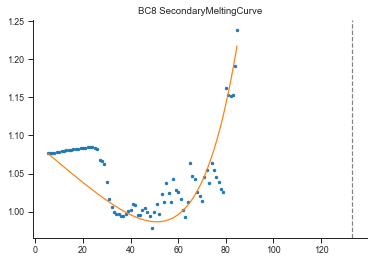

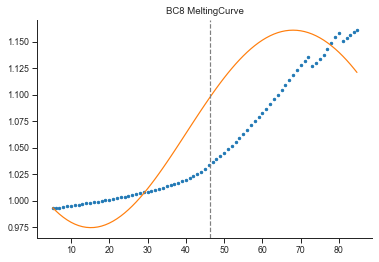

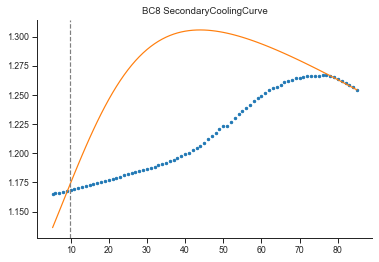

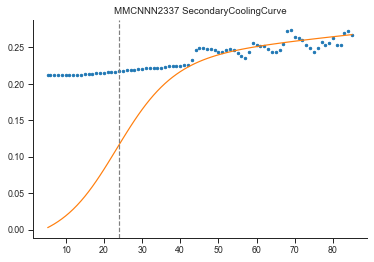

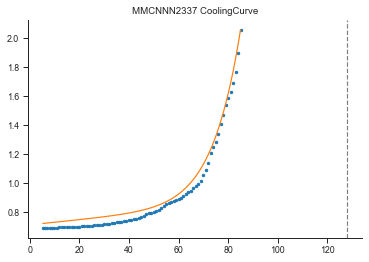

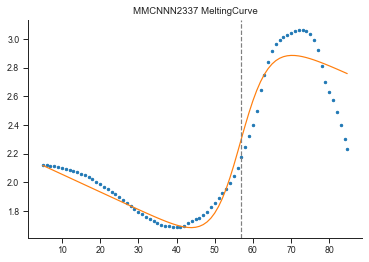

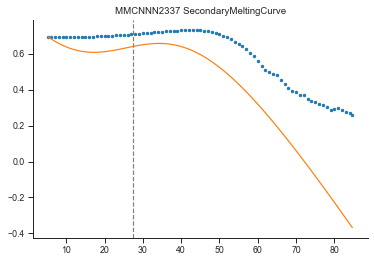

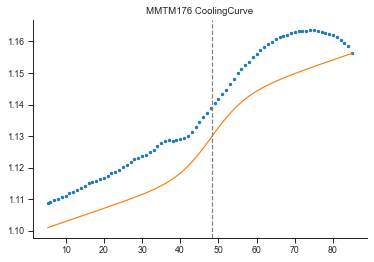

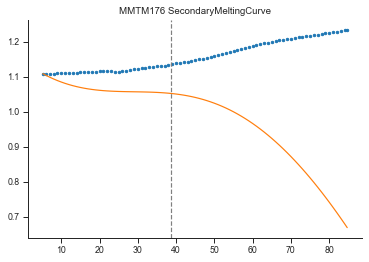

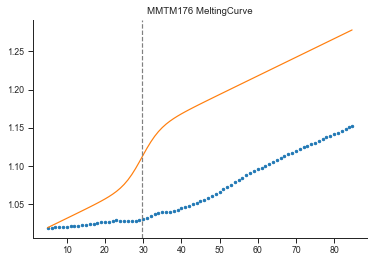

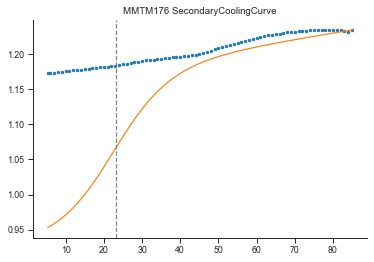

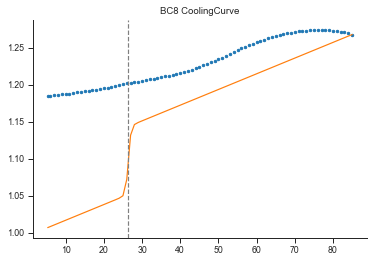

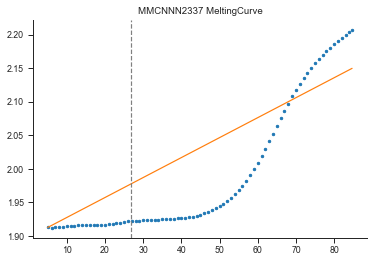

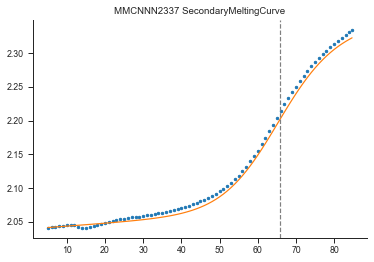

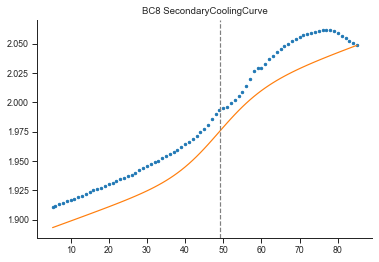

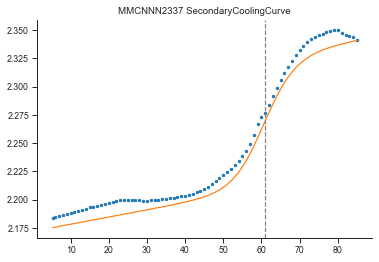

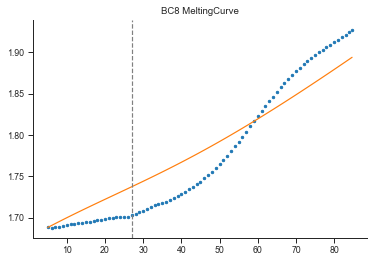

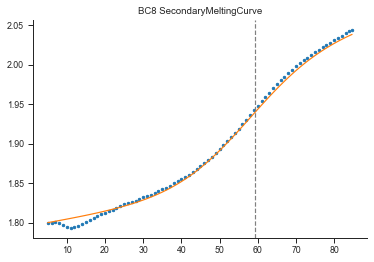

In [89]:
for i,row in result_df.loc[result_df.SEQID.isin(worst_match_seqid[:3])].iterrows():
    plot_curve_fit_result(row)